In [1]:
import pandas as pd                  # Pandas
import numpy as np                   # Numpy
from matplotlib import pyplot as plt # Matplotlib

# Package to implement ML Algorithms
import sklearn

# Import XGBoost
from xgboost import XGBRegressor

# Import MAPIE to calculate prediction intervals
from mapie.regression import MapieRegressor

# To calculate coverage score
from mapie.metrics import regression_coverage_score

# Package for data partitioning
from sklearn.model_selection import train_test_split

# Package to record time
import time

# Module to save and load Python objects to and from files
import pickle 

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')

# Display inline plots as vector-based (svg)
%config InlineBackend.figure_formats = ['svg']

# files to pickle compression (from ChatGPT)
import gzip
import shutil

%matplotlib inline

In [2]:
traffic_df = pd.read_csv('Traffic_Volume.csv')
traffic_df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,10/2/12 9:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,10/2/12 10:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,10/2/12 11:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,10/2/12 12:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,10/2/12 13:00,4918


In [3]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         61 non-null     object 
 1   temp            48204 non-null  float64
 2   rain_1h         48204 non-null  float64
 3   snow_1h         48204 non-null  float64
 4   clouds_all      48204 non-null  int64  
 5   weather_main    48204 non-null  object 
 6   date_time       48204 non-null  object 
 7   traffic_volume  48204 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 2.9+ MB


In [4]:
# this section was generated by ChatGPT
# convet date_time column to data/time datatype 
traffic_df['date_time'] = pd.to_datetime(traffic_df['date_time'])

# create columns to split date_time into numerical features 
traffic_df['year'] = traffic_df['date_time'].dt.year
traffic_df['month'] = traffic_df['date_time'].dt.month_name()
traffic_df['weekday'] = traffic_df['date_time'].dt.day_name()
traffic_df['hour'] = traffic_df['date_time'].dt.hour

# drop the original column
traffic_df = traffic_df.drop(columns=['date_time', 'year'])

traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         61 non-null     object 
 1   temp            48204 non-null  float64
 2   rain_1h         48204 non-null  float64
 3   snow_1h         48204 non-null  float64
 4   clouds_all      48204 non-null  int64  
 5   weather_main    48204 non-null  object 
 6   traffic_volume  48204 non-null  int64  
 7   month           48204 non-null  object 
 8   weekday         48204 non-null  object 
 9   hour            48204 non-null  int32  
dtypes: float64(3), int32(1), int64(2), object(4)
memory usage: 3.5+ MB


In [5]:
# select input and output features 
X = traffic_df.drop(columns=['traffic_volume'])
y = traffic_df['traffic_volume']

In [6]:
# one hot encoding for categorical variables 
X_encoded = pd.get_dummies(X)
X_encoded.head()

,temp,rain_1h,snow_1h,clouds_all,hour,holiday_Christmas Day,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,holiday_Martin Luther King Jr Day,...,month_November,month_October,month_September,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,288.28,0.0,0.0,40,9,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
1,289.36,0.0,0.0,75,10,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
2,289.58,0.0,0.0,90,11,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
3,290.13,0.0,0.0,90,12,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
4,291.14,0.0,0.0,75,13,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False


In [7]:
# data partioning into train and test sets 
train_X, test_X, train_y, test_y = train_test_split(X_encoded, y, test_size = 0.2, random_state = 42)

In [8]:
# Define the model
xgb = XGBRegressor(random_state = 42)

# Fit the model
start = time.time()            # Start Time
xgb.fit(train_X, train_y)  
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Training time: 0.42479443550109863s


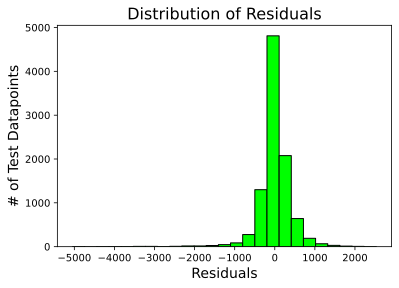

In [10]:
# Predict test set 
pred_xgb = xgb.predict(test_X)

# Calculate the residuals by subtracting the predicted values from the actual test values
all_residuals = test_y - pred_xgb

# Set up the figure with custom size and resolution (DPI)
plt.figure(figsize=(6, 4), dpi = 150)

# Plot the histogram of residuals
plt.hist(all_residuals, bins = 25, color = 'lime', edgecolor = 'black')

# Label X and Y axes
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('# of Test Datapoints', fontsize = 14)

# Set the title of the plot
plt.title('Distribution of Residuals', fontsize = 16)

# Adjust the font size of x and y ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

plt.savefig('residual_plot.svg')

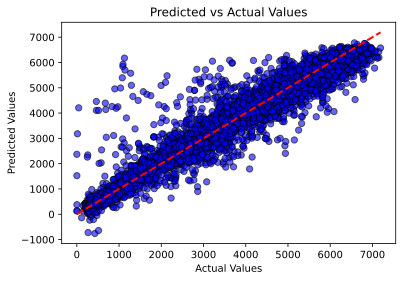

In [11]:
# Setting the figure size and resolution
plt.figure(figsize = (6, 4), dpi = 150)

# Scatter plot of actual vs predicted values
plt.scatter(test_y, pred_xgb, color = 'blue', alpha = 0.6, edgecolor = 'black', s = 40)

# 45-degree reference line (perfect predictions)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color = 'red', linestyle = '--', lw = 2)

# Axis labels and title
plt.xlabel('Actual Values', fontsize = 10)
plt.ylabel('Predicted Values', fontsize = 10)
plt.title('Predicted vs Actual Values', fontsize = 12)

# Adjust ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

plt.savefig('pred_vs_actual.svg')

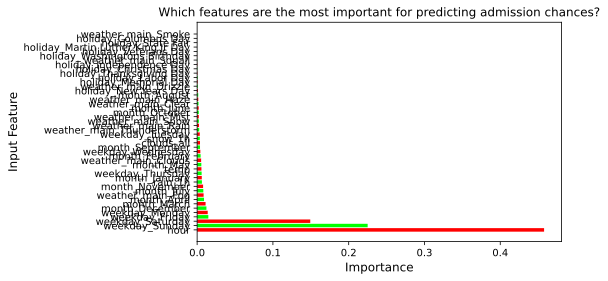

In [12]:
# Storing importance values from the trained model
importance = xgb.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize=(8, 4))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['red', 'lime'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for predicting admission chances?', fontsize = 12) 
plt.yticks(fontsize = 10) # fontsize of yticks
plt.xticks(fontsize = 10) # fontsize of xticks

plt.tight_layout();

plt.savefig('feature_imp.svg')

In [13]:
# Define MAPIE regressor
mapie = MapieRegressor(estimator = xgb, # Prediction model to use
                       n_jobs = -1,
                       random_state = 42)

# Fit mapie regressor on training data
start = time.time()  
mapie.fit(train_X, train_y)
stop = time.time()             
print(f"Training time: {stop - start}s")

alpha = 0.1 # For 90% confidence level

# Use mapie.predict() to get predicted values and intervals
y_test_pred, y_test_pis = mapie.predict(test_X, alpha = alpha)

Training time: 10.048059940338135s


In [14]:
# Storing results in a dataframe
predictions = test_y.to_frame()
predictions.columns = ['Actual Value']
predictions["Predicted Value"] = y_test_pred.round(2)
predictions["Lower Value"] = y_test_pis[:, 0].round(2)
predictions["Upper Value"] = y_test_pis[:, 1].round(2)

# Take a quick look
predictions.tail(5)

,Actual Value,Predicted Value,Lower Value,Upper Value
6401,2491,2685.550049,2109.45,3250.36
34004,5251,5228.100098,4639.08,5780.63
46086,2224,1909.339966,1497.42,2648.09
42579,2928,2781.399902,2284.11,3450.80
23709,910,593.780029,11.43,1153.45


In [15]:
coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis[:, 0], # Lower bound of prediction intervals
                                     y_test_pis[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")

Coverage: 91.66%


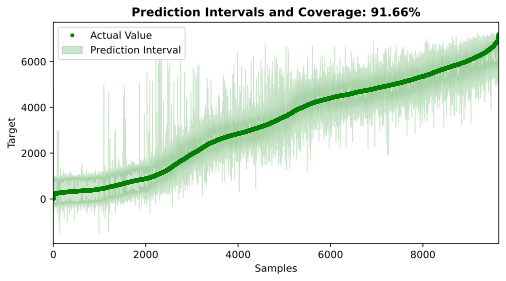

In [16]:
# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with green dots
plt.plot(sorted_predictions["Actual Value"], 'go', markersize=3, label="Actual Value")

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent green color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="green", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10);

plt.savefig('coverage.svg')

In [17]:
# Storing model as a pickle file 
traffic_pickle = open('traffic.pickle', 'wb')
pickle.dump(mapie, traffic_pickle)
traffic_pickle.close()